In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-pickle/riiid_train.pkl.gzip
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter


In [3]:
import pandas as pd
import dask.dataframe as dd
import pickle

In [ ]:
%%time

#pickle로 변환한 Train 데이터셋 가져오기
#refer. : https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets/
train = pd.read_pickle("../input/riiid-pickle/riiid_train.pkl.gzip")

print("Train size:", train.shape)

In [ ]:
#메모리 사용량 체크

train.memory_usage(deep=True)

In [ ]:
# 데이터셋 기초 정보

train.info()

"prior_question_had_explanation" 의 데이터타입이 object이면서 많은 메모리를 차지하고 있다.

해당 컬럼은, 0과1로 이루어진 이진 변수여야 하므로 이를 수정해준다.

In [ ]:
train["prior_question_had_explanation"]=train["prior_question_had_explanation"].astype("boolean")

In [ ]:
train.memory_usage(deep=True)

prior_question_had_explanation컬럼의 메모리 사용량이 줄어든 것을 확인할 수 있다.

In [ ]:
%%time

questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')

In [ ]:
train.head(10)

In [ ]:
# 유저의 수

print(f'We have {train.user_id.nunique()} unique users in our train set')

In [ ]:
# content_type_id 의 데이터 비율
# 0은 문제를 풀고 있다. 1은 강의를 보고 있다.


train.content_type_id.value_counts()

In [ ]:
print(f'We have {train.content_id.nunique()} content ids in our train set, of which {train[train.content_type_id == False].content_id.nunique()} are questions.')

content_id는 유저가 상호작용하고 있는, 컨텐츠의 아이디를 나타낸다. 만약 content_id_type==False 이면, 문제의 ID일 것이고 True이면 강의의 ID일 것이다.

총 13782의 content_id중 13523개가 강의를 나타내는 것을 확인할 수 있다.

In [ ]:
cids=train.content_id.value_counts()[:30]

fig=plt.figure(figsize=(12,6))
ax=cids.plot.bar()
plt.title("Thirty most used content id's")
plt.xticks(rotation=90)

#y축 자리수 변환
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

In [ ]:
print(f'We have {train.task_container_id.nunique()} unique Batches of questions or lectures.')

task_container_id는 설명을 보기전까지 유저가 받은 문제의 세트 번호이다. 

만약 3문제를 연속으로 받았다면, 그 3문제가 한 batch로 묶인다.

In [ ]:
train.user_answer.value_counts()

유저가 선택한 답의 분포이다. 총 4문항(0~3)으로 확인되며, -1은 답을 하지 않은 것이다.(강의를 봄)

In [ ]:
#1 year = 31536000000 ms
ts = train['timestamp']/(31536000000/12)
fig=plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("Histogram of timestamp")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

In [ ]:
print(f'Of the {train.user_id.nunique()} users in train we have {train[train.timestamp == 0].user_id.nunique()} users with a timestamp zero row.')

In [ ]:
# target value

# 강의를 보지 않은 것들만 체크
correct=train[train.answered_correctly!=-1].answered_correctly.value_counts(ascending=True)

fig=plt.figure(figsize=(12,4))
correct.plot.barh()

for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.xticks(rotation=0)
plt.show()


전체 데아터의 1/3이 오답인 것을 볼 수 있다.

In [ ]:
train.answered_correctly.value_counts()

In [ ]:
# timestamp와 answered_correctly의 관계
# 과연 사용 시간이 정답률과 관계가 있을까?


#make function that can also be used for other fields
def correct(field):
    
    #answered_correctly로 그룹화(0그룹, 1그룹 )후 각 그룹의 사이즈 구하기
    correct = train[train.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    
    #pivot을 이용하여 answered_correctly를 열로 전환(0열, 1열)
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    
    #정답의 비율
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)

In [ ]:
# timestamp와 answered_correctly의 관계
# 과연 사용 시간이 정답률과 관계가 있을까?


#시계열을 5구간으로 나누기
bin_labels_5=["Bin_1","Bin_2","Bine_3","Bin_4","Bin_5"]
train["ts_bin"]=pd.qcut(train["timestamp"],q=5,labels=bin_labels_5)


bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()


fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Percent answered_correctly for 5 bins of timestamp")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# 

task_id_correct=correct("task_container_id")

fig = plt.figure(figsize=(12,6))
task_id_correct.plot.hist(bins=40)
plt.title("Histogram of percent_correct grouped by task_container_id")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# 푼 문제 수와, 정답률의 관계
# 샘플 200

user_percent = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'the highest number of questions answered by a user is {user_percent.Answers.max()}')

In [ ]:
user_percent = user_percent.query('Answers <= 1000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered User")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")

# x,y와의 1차 회귀선 
z = np.polyfit(x, y, 1)

#1차 함수 
p = np.poly1d(z)

plt.plot(x,p(x),"r--")

plt.show()

대체적으로 푼 문제의 수가 올라갈수록 정답률도 상승하는 것을 볼 수 있지만, 푼 문제의 개수 0~100 부근에서 편차가 심한것을 볼 수 있다.

In [ ]:
content_percent=train[train.answered_correctly=-1].groupby("content_id")[""].agg(Mean="mean",Answers="count")

In [ ]:
#content_id 와 정답률의 관계
# 샘플 200

content_percent = train[train.answered_correctly != -1].groupby('content_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'The highest number of questions asked by content_id is {content_percent.Answers.max()}.')
print(f'Of {len(content_percent)} content_ids, {len(content_percent[content_percent.Answers > 25000])} content_ids had more than 25,000 questions asked.')

In [ ]:
content_percent = content_percent.query('Answers <= 25000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = content_percent.Answers
y = content_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered Content_id")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In [ ]:
#'prior_question_had_explanation'과 정답률의 관계
# 이전 문제에서 설명을 본 것이, 문제를 맞추는데 도움이 되나?

pq = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})
#pq.index = pq.index.astype(str)
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
pq.plot.barh()
# for i, v in zip(pq.index, pq.values):
#     plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Answered_correctly versus Prior Question had explanation")
plt.xlabel("Percent answered correctly")
plt.ylabel("Prior question had explanation")
plt.xticks(rotation=0)
plt.show()


설명을 보는 것이, 다음 문제를 맞히는데 확실히 도움이 되는 것을 확인 할 수 있다.

In [ ]:
# 1개의 bundle을 푸는데 걸리는 평균 시간

pq = train[train.answered_correctly != -1]
pq = pq[['prior_question_elapsed_time', 'answered_correctly']]
pq = pq.groupby(['answered_correctly']).agg({'answered_correctly': ['count'], 'prior_question_elapsed_time': ['mean']})

pq

오답이든 정답이든, 문제 풀이에 걸리는 시간은 큰 차이가 없는 것을 볼 수 있다.

In [ ]:
mean_pq = train.prior_question_elapsed_time.astype("float64").mean()

condition = ((train.answered_correctly != -1) & (train.prior_question_elapsed_time.notna()))
pq = train[condition][['prior_question_elapsed_time', 'answered_correctly']].sample(n=200, random_state=1)
pq = pq.set_index('prior_question_elapsed_time').iloc[:,0]

fig = plt.figure(figsize=(12,6))
x = pq.index
y = pq.values
plt.scatter(x, y, marker='o')
plt.title("Answered_correctly versus prior_question_elapsed_time")
plt.xticks(rotation=0)
plt.xlabel("Prior_question_elapsed_time")
plt.ylabel("Answered_correctly")
plt.vlines(mean_pq, ymin=-0.1, ymax=1.1)
plt.text(x= 27000, y=0.4, s='mean')
plt.text(x=80000, y=0.6, s='trend')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

하지만 약간의 downward trend가 있는 것을 확인 할 수 있다.
즉 문제 풀이 시간이 늘어날수록 정답률도 약소하게 떨어진다.
(아마 자신있는 문제라면 떠 빨리 풀고 넘어가지 않을까?)

## Questions 데이터셋 

In [ ]:
questions.head()

In [ ]:
questions.shape

In [ ]:
# tags 컬럼 결측치 확인

questions[questions.tags.isna()]

In [ ]:
train.query('content_id == "10033" and answered_correctly != -1')

태그에 결측치가 있는 문제는 단 한번 나온 것을 확인할 수 있다.

In [ ]:
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'There are {len(tags)} different tags')

In [ ]:
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()

correct = train[train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions.head()

In [ ]:
questions.head()

해당 문제에 묶인 태그들을 리스트 형태로 변환, 해당 문제를 맞힌 개수 틀린 개수 추가

In [ ]:
correct.head()

In [ ]:
%%time

tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head()

In [ ]:
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]

fig = plt.figure(figsize=(12,6))
x = tags_select.index
y = tags_select.values
clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("Ten hardest and ten easiest tags")
plt.xlabel("Tag")
plt.ylabel("Percent answers correct of questions with the tag")
plt.xticks(rotation=90)
plt.show()

태그에 따라 정(오)답률이 차이가 확연히 나는 것을 볼 수 있다.

In [ ]:
tags_select = tags_df.sort_values(by = "Total_questions", ascending = False).iloc[:30,:]
tags_select = tags_select["Total_questions"]

fig = plt.figure(figsize=(12,6))
ax = tags_select.plot.bar()
plt.title("Thirty tags with most questions answered")
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

tag에 따른 문제의 개수이다. 
참고로 정답률이 가장 낮은 24번 태그의 문제 수는 25만여개 정도밖에 되지 않는다. 이는 위의 그래프에도 나오지 않을 정도로 상당히 작은 숫자이다.

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1 = questions.groupby("part").count()['question_id'].plot.bar()
plt.title("Counts of part")
plt.xlabel("Part")
plt.xticks(rotation=0)

part = questions.groupby('part').agg({'Wrong': ['sum'], 'Right': ['sum']})
part['Percent_correct'] = part.Right/(part.Right + part.Wrong)
part = part.iloc[:,2]

ax2 = fig.add_subplot(212)
plt.bar(part.index, part.values)
for i, v in zip(part.index, part.values):
    plt.text(i, v, round(v,2), color='white', fontweight='bold', fontsize=14, va='top', ha='center')

plt.title("Percent_correct by part")
plt.xlabel("Part")
plt.xticks(rotation=0)
plt.tight_layout(pad=2)
plt.show()

파트별로 문제의 수가 다르며, 파트마다 정답률이 다른 것도 확인할 수 있다. 

## Lectures 데이터 셋

In [ ]:
lectures.head()

In [ ]:
print(f'There are {lectures.shape[0]} lecture_ids.')

In [ ]:
lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Types of lectures")
plt.xlabel("type_of")
plt.ylabel("Count lecture_id")
plt.xticks(rotation=0)
plt.show()

강의 유형별 데이터의 수는 위와 같다.

In [ ]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("User watches lectures: Percent_correct")
plt.xlabel("Percent correct")
plt.ylabel("User watched at least one lecture")
plt.xticks(rotation=0)
plt.show()

강의를 본 것이 정답률 상승에 도움을 줄 수  있는 것으로 확인된다.

In [ ]:
batch_lect = train.groupby(["task_container_id", "answered_correctly"]).size().unstack()
batch_lect.columns = ['Lecture', 'Wrong', 'Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect = batch_lect.astype('Int64')
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect['Percent_lecture'] = batch_lect.Lecture/(batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect.sort_values(by = "Percent_lecture", ascending = False)

print(f'The highest number of lectures watched within a single task_container_id is {batch_lect.Lecture.max()}.')

In [ ]:
batch_lect.head()

In [ ]:
batch = batch_lect.iloc[:, 3:]

fig = plt.figure(figsize=(12,6))
x = batch.Percent_lecture
y = batch.Percent_correct
plt.scatter(x, y, marker='o')
plt.title("Percent lectures in a task_container versus percent answered correctly")
plt.xticks(rotation=0)
plt.xlabel("Percent lectures")
plt.ylabel("Percent answered correctly")

plt.show()

percent lectures와 percent_correct 사이에 큰 연관성은 없어보인다.

In [ ]:
batch_lect['Has_lecture'] = np.where(batch_lect.Lecture == 0, False, True)
print(f'We have {batch_lect[batch_lect.Has_lecture == True].shape[0]} task_container_ids with lectures and {batch_lect[batch_lect.Has_lecture == False].shape[0]} task_container_ids without lectures.')

In [ ]:
batch_lect = batch_lect[['Wrong', 'Right', 'Has_lecture']]
batch_lect = batch_lect.groupby("Has_lecture").sum()
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect[['Percent_correct']]
batch_lect

한 배치안에 강의를 가지고 있는 것이, 정답을 맞히는데 도움이 되는가? 
-> 큰 도움은 안된다

## Example test

In [ ]:
example_test.shape

In [ ]:
example_test.head()

In [ ]:
batches_test = set(list(example_test.task_container_id.unique()))
batches_train = set(list(train.task_container_id.unique()))
print(f'All batches in example_test are also in train is {batches_test.issubset(batches_train)}.')

In [ ]:
user_test = set(list(example_test.user_id.unique()))
user_train = set(list(train.user_id.unique()))

print(f'User_ids in example_test but not in train: {user_test - user_train}.')

## Baseline Model

In [ ]:
#this clears everything loaded in RAM, including the libraries
#%reset -f

In [22]:
%%time
cols_to_load = ['row_id', 'user_id', 'answered_correctly', 'content_id', 'prior_question_had_explanation', 'prior_question_elapsed_time']
train = pd.read_pickle("../input/riiid-pickle/riiid_train.pkl.gzip")[cols_to_load]
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')



CPU times: user 20.1 s, sys: 9.11 s, total: 29.2 s
Wall time: 32.7 s


In [23]:
%%time

questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')

CPU times: user 21.2 ms, sys: 2 µs, total: 21.2 ms
Wall time: 37.7 ms


In [24]:
train.head()

,row_id,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time
0,0,115,1,5692,<NA>,NaN
1,1,115,1,5716,False,37000.0
2,2,115,1,128,False,55000.0
3,3,115,1,7860,False,19000.0
4,4,115,1,7922,False,11000.0


In [25]:
train.shape

(101230332, 6)

In [26]:
#adding user features
user_df = train[train.answered_correctly != -1].groupby('user_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
user_df.columns = ['user_id', 'user_questions', 'user_mean']

user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect = user_lect[['Lecture']].fillna(0).astype('int8')
#user_lect = user_lect.astype('int8')
user_lect['watches_lecture'] = np.where(user_lect.Lecture > 0, 1, 0)
user_lect = user_lect.reset_index()
user_lect = user_lect[['user_id', 'watches_lecture']]

user_df = user_df.merge(user_lect, on = "user_id", how = "left")
del user_lect
user_df.head()

,user_id,user_questions,user_mean,watches_lecture
0,115,46,0.695652,0
1,124,30,0.233333,0
2,2746,19,0.578947,1
3,5382,125,0.672000,1
4,8623,109,0.642202,1


user_feature를 추가하는 것은 일종의 편법이다. 왜냐하면 시계열에서 미래의 정보는 사용되면 안된다. 하지만 간편하게 베이스라인 모델을 만들기 위한 방법으로 이를 사용한다.

In [27]:
%%time
#adding content features
content_df = train[train.answered_correctly != -1].groupby('content_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
content_df.columns = ['content_id', 'content_questions', 'content_mean']
content_df.head()

CPU times: user 18.5 s, sys: 1.65 s, total: 20.1 s
Wall time: 20.1 s


,content_id,content_questions,content_mean
0,0,6903,0.907721
1,1,7398,0.890646
2,2,44905,0.554281
3,3,22973,0.779437
4,4,31736,0.613215


In [28]:
%%time
#using one of the validation sets composed by tito
cv2_train = pd.read_pickle("../input/cv-strategy/cv2_train.pickle")['row_id']
cv2_valid = pd.read_pickle("../input/cv-strategy/cv2_valid.pickle")['row_id']

CPU times: user 103 ms, sys: 425 ms, total: 528 ms
Wall time: 4.77 s


In [29]:
import gc

In [30]:
train = train[train.answered_correctly != -1]

#save mean before splitting
#please be aware that there is an issues with train.prior_question_elapsed_time.mean()
#see https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/195032
mean_prior = train.prior_question_elapsed_time.astype("float64").mean()

validation = train[train.row_id.isin(cv2_valid)]
train = train[train.row_id.isin(cv2_train)]

validation = validation.drop(columns = "row_id")
train = train.drop(columns = "row_id")

del cv2_train, cv2_valid


In [31]:
gc.collect()

123

In [32]:
from sklearn.preprocessing import LabelEncoder

In [33]:
label_enc = LabelEncoder()

train = train.merge(user_df, on = "user_id", how = "left")
train = train.merge(content_df, on = "content_id", how = "left")
train['content_questions'].fillna(0, inplace = True)
train['content_mean'].fillna(0.5, inplace = True)
train['watches_lecture'].fillna(0, inplace = True)
train['user_questions'].fillna(0, inplace = True)
train['user_mean'].fillna(0.5, inplace = True)
train['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
train['prior_question_had_explanation'].fillna(False, inplace = True)
label_enc.fit(train['prior_question_had_explanation'])
train['prior_question_had_explanation'] = label_enc.transform(train['prior_question_had_explanation'])
train[['content_questions', 'user_questions']] = train[['content_questions', 'user_questions']].astype(int)
train.sample(5)

,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time,user_questions,user_mean,watches_lecture,content_questions,content_mean
1147922,25223725,1,4481,1,20000.0,9447,0.807135,1,22003,0.762169
8987120,210126291,0,6777,0,23000.0,9611,0.756425,0,19376,0.332783
5905580,136624057,1,5153,1,19000.0,110,0.590909,0,18161,0.675679
4432454,100705022,1,773,1,19000.0,69,0.739130,0,45049,0.517126
7174287,167245189,0,5701,1,22000.0,119,0.529412,0,26096,0.785523


In [34]:
validation = validation.merge(user_df, on = "user_id", how = "left")
validation = validation.merge(content_df, on = "content_id", how = "left")
validation['content_questions'].fillna(0, inplace = True)
validation['content_mean'].fillna(0.5, inplace = True)
validation['watches_lecture'].fillna(0, inplace = True)
validation['user_questions'].fillna(0, inplace = True)
validation['user_mean'].fillna(0.5, inplace = True)
validation['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
validation['prior_question_had_explanation'].fillna(False, inplace = True)
validation['prior_question_had_explanation'] = label_enc.transform(validation['prior_question_had_explanation'])
validation[['content_questions', 'user_questions']] = validation[['content_questions', 'user_questions']].astype(int)
validation.sample(5)

,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time,user_questions,user_mean,watches_lecture,content_questions,content_mean
214129,197052416,0,12247,1,29000.0,5918,0.672525,1,1546,0.724450
42774,43107319,1,4077,1,22000.0,474,0.689873,1,10722,0.299571
102358,98981328,1,4405,1,46000.0,262,0.473282,1,31693,0.694854
91188,88925709,0,2063,0,19000.0,30,0.400000,0,176043,0.163119
194480,180752603,1,278,1,15000.0,591,0.548223,1,15275,0.654403


In [37]:
# features = ['user_questions', 'user_mean', 'content_questions', 'content_mean', 'watches_lecture',
#             'prior_question_elapsed_time', 'prior_question_had_explanation']

features = ['user_questions', 'user_mean', 'content_questions', 'content_mean', 'prior_question_elapsed_time']


#for now just taking 10.000.000 rows for training
train = train.sample(n=10000000, random_state = 1,replace=True)

y_train = train['answered_correctly']
train = train[features]

y_val = validation['answered_correctly']
validation = validation[features]

"watches_lecture" and "prior_question_had_explanation"은 피처중요도가 낮으므로, 이 둘을 제외한 더 간단한 베이스라인 모델 생성

In [36]:
import lightgbm as lgb

In [38]:
params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 2020,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt" #default
         }

In [39]:
lgb_train=lgb.Dataset(train,y_train,categorical_feature=None)
lgb_eval=lgb.Dataset(validation,y_val,categorical_feature=None)
del train,y_train,validation,y_val
gc.collect()

88

In [41]:
%%time
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8
)

Training until validation scores don't improve for 8 rounds
[50]	training's auc: 0.757036	valid_1's auc: 0.769531
[100]	training's auc: 0.757738	valid_1's auc: 0.769898
Early stopping, best iteration is:
[129]	training's auc: 0.757964	valid_1's auc: 0.770015
CPU times: user 17min 46s, sys: 16 s, total: 18min 2s
Wall time: 5min 40s


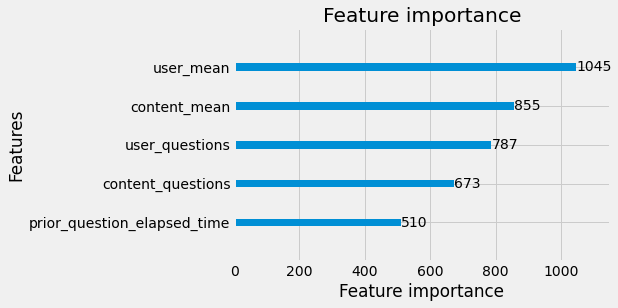

In [43]:
lgb.plot_importance(model)
plt.show()

In [46]:
import riiideducation

In [47]:
env = riiideducation.make_env()

In [48]:
iter_test=env.iter_test()

In [54]:
for (test_df, sample_prediction_df) in iter_test:
    test_df = test_df.merge(user_df, on = "user_id", how = "left")
    test_df = test_df.merge(content_df, on = "content_id", how = "left")
    test_df['content_questions'].fillna(0, inplace = True)
    test_df['content_mean'].fillna(0.5, inplace = True)
    test_df['watches_lecture'].fillna(0, inplace = True)
    test_df['user_questions'].fillna(0, inplace = True)
    test_df['user_mean'].fillna(0.5, inplace = True)
    test_df['prior_question_elapsed_time'].fillna(mean_prior, inplace = True)
    test_df['prior_question_had_explanation'].fillna(False, inplace = True)
    test_df['prior_question_had_explanation'] = label_enc.transform(test_df['prior_question_had_explanation'])
    test_df[['content_questions', 'user_questions']] = test_df[['content_questions', 'user_questions']].astype(int)
    test_df['answered_correctly'] =  model.predict(test_df[features])
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])